In [1]:
from utils import commons
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
import joblib


In [36]:
# Define paths (constants are usually uppercase)
TRAIN_TRANSACTION_PATH = '../input/train_transaction.csv'
TRAIN_IDENTITY_PATH = '../input/train_identity.csv'

# Execute function
df_transaction, df_identity = commons.extract_data(TRAIN_TRANSACTION_PATH, TRAIN_IDENTITY_PATH)

Loading data from: ../input/train_transaction.csv and ../input/train_identity.csv...
Data successfully loaded! Shapes: (590540, 394), (144233, 41)


In [38]:
import importlib
importlib.reload(commons)
df_merged = commons.merge_datasets(df_transaction, df_identity)

🔗 Merging datasets on TransactionID...
✅ Merge complete! New shape: (590540, 434)


In [39]:
df_merged.head(4)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# 2. Target Analysis
fraud_rate = df_merged['isFraud'].mean() * 100
print(f"Fraud Rate: {fraud_rate:.2f}%")

Fraud Rate: 3.50%


In [42]:
# Feature Engineering: Extract hour of the day from TransactionDT
# This assumes TransactionDT is in seconds
df_merged['hour'] = (df_merged['TransactionDT'] // 3600) % 24

In [10]:
# df_transaction = commons.reduce_mem_usage(df_transaction)

Initial memory usage: 1779.66 MB
Final memory usage: 1015.98 MB
Decreased by: 42.9%


In [5]:
# df_identity = commons.reduce_mem_usage(df_identity)

Initial memory usage: 45.12 MB
Final memory usage: 32.46 MB
Decreased by: 28.0%


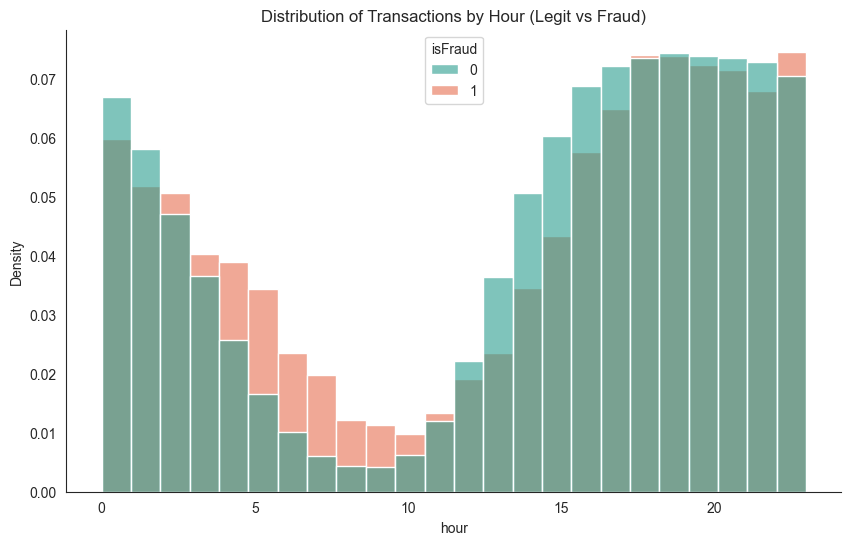

In [43]:
# 1. Reseta as configurações para o padrão
plt.rcdefaults()

# 2. Força o fundo branco no nível da biblioteca
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

# 3. Define o estilo do Seaborn (sem as grades cinzas)
sns.set_style("white")

plt.figure(figsize=(10, 6))

# Seu plot
ax = sns.histplot(
    data=df_merged,
    x='hour',
    hue='isFraud',
    stat='density',
    common_norm=False,
    bins=24,
    palette={0: '#2a9d8f', 1: '#e76f51'},
    alpha=0.6
)

# Remove as bordas desnecessárias
sns.despine()

plt.title('Distribution of Transactions by Hour (Legit vs Fraud)')
plt.show()

In [44]:
# 1. Define truly categorical text features
categorical_features = [
    'ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
    'DeviceType', 'DeviceInfo', 'id_12', 'id_13', 'id_14', 'id_15',
    'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31',
    'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38'
]

# Ensure only existing columns are processed (safety check)
categorical_features = [col for col in categorical_features if col in df_merged.columns]

# 2. Fill missing values with a placeholder
df_merged[categorical_features] = df_merged[categorical_features].fillna('MISSING')

# 3. Configure the Encoder
# Using int32 saves memory compared to the default float64
encoder = OrdinalEncoder(
    dtype='int32',
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

# 4. Apply Transformation
# Ensure data is cast to string to avoid mixed-type errors
df_merged[categorical_features] = encoder.fit_transform(df_merged[categorical_features].astype(str))

# 5. Export for later use (Production/Test inference)
joblib.dump(encoder, '../models/ordinal_encoder.joblib')

print("Categorical encoding complete!")

Categorical encoding complete!


In [46]:
# 1. Identify redundant V columns
v_cols_to_drop = commons.get_redundant_features(df_merged, prefix='V', threshold=0.90)

# 2. Drop them from the dataframe
df_merged.drop(v_cols_to_drop, axis=1, inplace=True)

# 3. CRITICAL: Save the list for the Test set
# You must drop the SAME columns in your test data to keep the model consistent
joblib.dump(v_cols_to_drop, '../models/redundant_v_columns.joblib')

print("Redundant variables dropped successfully!")


Found 181 redundant 'V' columns with correlation > 0.9.
Redundant variables dropped successfully!


In [47]:
df_transaction.shape

(590540, 394)

In [48]:
# Group statistics completed for columns
# import importlib
# importlib.reload(commons)
card_features = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']

# By default, it calculates 'mean' and 'std' for 'TransactionAmt'
df_merged = commons.add_group_stats(df_merged, group_cols=card_features)

print(f"Group statistics completed for columns: {card_features}")

Created 12 new statistical features.
Group statistics completed for columns: ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']


In [49]:
# Define the columns to be frequency-encoded
count_features = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'P_emaildomain']

# Apply the function
df_merged = commons.add_frequency_encoding(df_merged, count_features)


Frequency encoding completed for: ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'P_emaildomain']


In [59]:
# Apply Log Transformation to TransactionAmt
# We use np.log1p (log(1+x)) to avoid issues with zero values, though Amt is usually > 0
df_merged['TransactionAmt_Log'] = np.log1p(df_merged['TransactionAmt'])
df_merged = commons.reduce_mem_usage(df_merged)
df_merged.to_parquet('../input/train_v1.parquet', engine='fastparquet', index=False)

print("Log transformation on TransactionAmt completed.")

Initial memory usage: 593.59 MB
Final memory usage: 593.59 MB
Decreased by: 0.0%
Log transformation on TransactionAmt completed.
